In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [4]:
train_dir = "/kaggle/input/fer2013/train" #passing the path with training images
test_dir = "/kaggle/input/fer2013/test"   #passing the path with testing images

In [5]:
img_size = 48 #original size of the image

In [6]:

train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [7]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size =64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


For IMAGE LOADING

In [8]:
from PIL import Image
import os, os.path
classes=["angry","disgust","fear","happy","neutral","sad","surprise"]

d=dict()
for clas in classes:
    imgs =[]
    count=0
    path = "/kaggle/input/fer2013/train/"+clas
    valid_images = [".jpg",".gif",".png",".tga"]
    for f in os.listdir(path):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        imgs.append(os.path.join(path,f))
        count+=1
        if count==4:
            break
    d[clas]=imgs

In [9]:
def display_images(path,figure,label):
    fig,rows,columns,i=figure
    fig.add_subplot(rows, columns, i)
    img = image.load_img(path,target_size = (48,48),color_mode = "grayscale")
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)

In [10]:
rows=7
columns=4

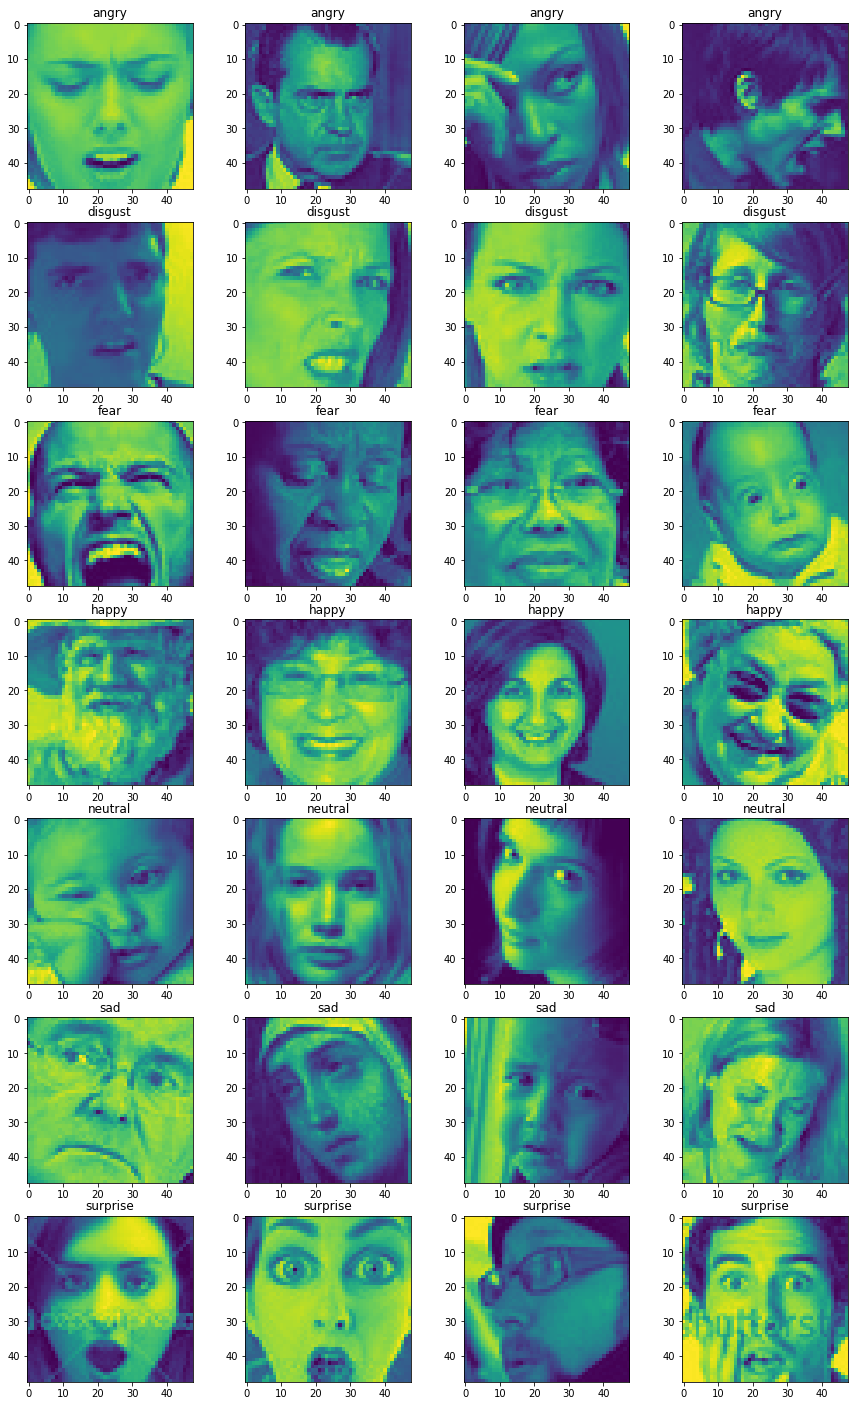

In [11]:
fig = plt.figure(figsize=(15,25))
i=1
for clas in classes:
    paths=d[clas]
    for path in paths:
        display_images(path,(fig,rows,columns,i),clas)
        i+=1

Running a Deep neural network

In [12]:
model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
    
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

2022-12-08 08:46:09.813485: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 08:46:09.814822: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 08:46:09.815482: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 08:46:09.816351: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [13]:
epochs = 60
batch_size = 64

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

We need to train the model

In [15]:
history = model.fit(x = train_generator,epochs = epochs,validation_data = validation_generator)

2022-12-08 08:46:16.238895: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2022-12-08 08:46:18.651080: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


359/359 [==============================] - 116s 298ms/step - loss: 9.2652 - accuracy: 0.1878 - val_loss: 8.5575 - val_accuracy: 0.1795
Epoch 2/60
359/359 [==============================] - 31s 86ms/step - loss: 8.1673 - accuracy: 0.2256 - val_loss: 7.4464 - val_accuracy: 0.2751
Epoch 3/60
359/359 [==============================] - 31s 86ms/step - loss: 7.1009 - accuracy: 0.2520 - val_loss: 6.4033 - val_accuracy: 0.3024
Epoch 4/60
359/359 [==============================] - 32s 89ms/step - loss: 6.0868 - accuracy: 0.2778 - val_loss: 5.4078 - val_accuracy: 0.3429
Epoch 5/60
359/359 [==============================] - 31s 88ms/step - loss: 5.1878 - accuracy: 0.3126 - val_loss: 4.6637 - val_accuracy: 0.3568
Epoch 6/60
359/359 [==============================] - 31s 87ms/step - loss: 4.4415 - accuracy: 0.3429 - val_loss: 3.9829 - val_accuracy: 0.4134
Epoch 7/60
359/359 [==============================] - 31s 87ms/step - loss: 3.8240 - accuracy: 0.3724 - val_loss: 3.4263 - val_accuracy: 0.4337
E

Validation Accuracy=0.6732

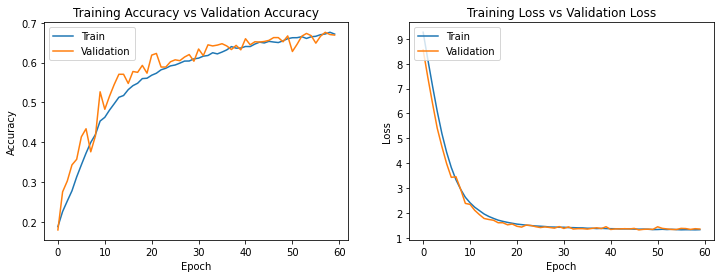

In [32]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [17]:
model.save('model_optimal.h5')

(48, 48)


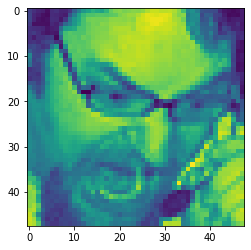

In [33]:
img = image.load_img("/kaggle/input/fer2013/test/angry/PrivateTest_10131363.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape) #prints (48,48) that is the shape of our image

In [34]:
img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,48,48,1)
result = model.predict(img)
result = list(result[0])
print(result)

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [35]:
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

In [36]:
img_index = result.index(max(result))
print(label_dict[img_index])
plt.show()

Angry


Testing the model

In [37]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

23/23 [==============================] - 1s 55ms/step - loss: 1.3474 - accuracy: 0.6690
final train accuracy = 72.66 , validation accuracy = 66.90


In [38]:
from sklearn.model_selection import GridSearchCV

In [39]:
class_dict=train_generator.class_indices
labels= train_generator.labels
file_names= train_generator.filenames 

In [40]:
new_dict=dict()

In [41]:
len(labels)

22968

In [42]:
img=image.load_img("/kaggle/input/fer2013/train/"+file_names[0]) #/kaggle/input/fer2013/train/angry/Training_10118481.jpg

In [44]:
for key,value in class_dict.items():
        new_dict[value]=key 

In [45]:
new_dict

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [47]:
x_train,y_train=next(train_generator)

In [51]:
batch_size = [128, 256,512]
epochs = [60,80,100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid,scoring="accuracy")
grid_result = grid.fit(x_train,y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

TypeError: Cannot clone object '<keras.engine.sequential.Sequential object at 0x7fe45d127f50>' (type <class 'keras.engine.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [52]:
batch_size = [128, 256,512]
epochs = [60,80,100]
for batch in batch_size:
    train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = batch,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
    validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                                  target_size = (img_size,img_size),
                                                                  batch_size =batch,
                                                                  color_mode = "grayscale",
                                                                  class_mode = "categorical",
                                                                  subset = "validation"
                                                                 )
    for epoch in epochs:
        history = model.fit(x = train_generator,epochs = epoch,validation_data = validation_generator)

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.
Epoch 1/60
180/180 [==============================] - 31s 169ms/step - loss: 1.2569 - accuracy: 0.6940 - val_loss: 1.3078 - val_accuracy: 0.6844
Epoch 2/60
180/180 [==============================] - 30s 167ms/step - loss: 1.2163 - accuracy: 0.7009 - val_loss: 1.2839 - val_accuracy: 0.6774
Epoch 3/60
180/180 [==============================] - 30s 169ms/step - loss: 1.2032 - accuracy: 0.7012 - val_loss: 1.2608 - val_accuracy: 0.6844
Epoch 4/60
180/180 [==============================] - 30s 165ms/step - loss: 1.1844 - accuracy: 0.7047 - val_loss: 1.3384 - val_accuracy: 0.6571
Epoch 5/60
180/180 [==============================] - 30s 168ms/step - loss: 1.1764 - accuracy: 0.7026 - val_loss: 1.3013 - val_accuracy: 0.6767
Epoch 6/60
180/180 [==============================] - 30s 167ms/step - loss: 1.1812 - accuracy: 0.7020 - val_loss: 1.2516 - val_accuracy: 0.6823
Epoch 7/60
180/180 [=========================

KeyboardInterrupt: 

EPOCHS- 100
VALIDATION ACCURACY - 72.93%
BATCH SIZE - 134